# Download model variables

Download as raster layers covering your study area envelope, including:

- At least one **soil** variable from the [POLARIS dataset](http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/) (**find thresholds**)
    - [POLARIS: 30-meter probabilistic soil series map of contiguous US](https://pubs.usgs.gov/publication/70170912)
    - <https://scholars.duke.edu/publication/1381493>
    - <https://gee-community-catalog.org/projects/polaris/>
    - NW Chaney et al. (2019) POLARIS Soil Properties: 30-m Probabilistic Maps of Soil Properties Over the Contiguous United States. [DOI: 10.1029/2018WR022797](https://doi.org/10.1029/2018WR022797)
    - Elsa Culler EarthLab Videos
        - [Accessing and formatting URLS for POLARIS data](https://cuboulder.zoom.us/rec/share/imhCGJcrCgSoE1cJjg02r86GMNjiRz0jwVMJ5c0uWNwBCD5D_0kLSl3CaqLdDI2a.ucGta1EEAiirDUop)
        - [Looping through multiple tiles of POLARIS data](https://cuboulder.zoom.us/rec/share/3S7pGOSv7jztZTvg4RSXLj-GicnHwusIDIEDoETZbUN7ivkc6Ryi5GAJyX9Ly6h2.VXl6iFmLChjjUyOg)
- Elevation from the SRTM (available from the [earthaccess API](https://github.com/nsidc/earthaccess/))
- At least one **climate** variable from the [MACAv2 THREDDS data server](http://thredds.northwestknowledge.net:8080/thredds/reacch_climate_CMIP5_macav2_catalog2.html).
    - Pick 2 of these
    - [GeoNetwork](https://docs.geonetwork-opensource.org/4.2/):
[THREDDS Harvesting](https://docs.geonetwork-opensource.org/4.2/user-guide/harvesting/harvesting-thredds/)

## POLARIS Dataset

Considering `sand` percentage `mean`. POLARIS data are available at 6 depths, and Bluestem has roots down to 5 feet (150 cm), which is the lowest strata measured (100-200 cm). Data in the
[sand 100-200 cm directory](http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/sand/mean/100_200/)
are saved as separate tif files by longitude.
Buffalo Gap National Grassland is at (centroid) 43.4375° N, 103.0505° W, while Oglala National Grassland is at 42.9404° N, 103.5900° W. That probably suggests

- [lat4344_lon-103-102.tif](http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/sand/mean/100_200/lat4344_lon-103-102.tif) (33M)
- [lat4344_lon-104-103.tif](http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/sand/mean/100_200/lat4344_lon-104-103.tif) (33M)

In [1]:
pip install --quiet ~/Documents/GitHub/landmapy

Note: you may need to restart the kernel to use updated packages.


In [2]:
from landmapy.habitat import create_data_dir, merge_soil, maca_year, process_maca
from landmapy.index import redline_over_index

import rioxarray as rxr

More packages for slope and aspect

In [3]:
import earthaccess
import xrspatial
import rioxarray as rxr
import rioxarray.merge as rxrmerge

import os
from glob import glob

/Users/brianyandell/miniconda3/envs/earth-analytics-python/lib/python3.11/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
data_dir = create_data_dir('habitat')
data_dir

'/Users/brianyandell/earth-analytics/data/habitat'

### Single POLARIS TIFF

In [5]:
soil_url = (
    "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/"
    "sand/"
    "mean/"
    "100_200/"
    "lat4344_lon-105-104.tif"
)
soil_url

'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/sand/mean/100_200/lat4344_lon-105-104.tif'

In [7]:
soil_da = rxr.open_rasterio(
    soil_url,
    mask_and_scale=True
).squeeze()
soil_da

<xarray.DataArray (y: 3600, x: 3600)> Size: 52MB
[12960000 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 29kB -105.0 -105.0 -105.0 ... -104.0 -104.0 -104.0
  * y            (y) float64 29kB 44.0 44.0 44.0 44.0 ... 43.0 43.0 43.0 43.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area

In [9]:
#soil_da.plot(cmap='terrain')

### Multiple POLARIS TIFFs

Get boundary for study. Fake Denver for now.
Determine `lat` and `lon` based on site.
Set up `for` loop.

Code below is for `soil_var="sand"`. We also want to do `soil_var="ph"`.

In [5]:
%store -r buffalo_gdf
print(buffalo_gdf.total_bounds)
#buffalo_gdf.plot()

[-104.05473027   42.74093601 -101.47233564   43.99459902]


Download URL list from `buffalo_gdf` and merge into DataArray `buffalo_da` with `merge_soil()`.
This also bounds `buffalo_da` based on `buffalo_gdf`.

In [6]:
%store -r buffalo_da
try:
    buffalo_da
except NameError:
    buffalo_da = merge_soil(buffalo_gdf)
    %store buffalo_da
    print("buffalo_da created and stored")
else:
    print("buffalo_da already exists")

buffalo_da already exists


Changes desired for plot below:

- Different colors by grassland.
- crop to bounding box (with extra).

In [41]:
buffalo_gdf

,OBJECTID,NATIONALGRASSLANDID,GRASSLANDNAME,GIS_ACRES,SHAPEAREA,SHAPELEN,geometry
12,185977,295518010328,Buffalo Gap National Grassland,654877.177,0.295196,33.006274,"MULTIPOLYGON (((-102.3384 43.93679, -102.33339..."
15,185980,295521010328,Oglala National Grassland,215804.927,0.096279,1.970612,"POLYGON ((-103.72478 43.001, -103.725 43.001, ..."


In [7]:
buffalo_gdf['color'] = ['white','red']

In [8]:
buffalo_gdf['color'].values[0]

'white'

In [49]:
import cartopy.crs as ccrs # CRSs
import matplotlib.pyplot as plt # Overlay raster and vector data

print(type(buffalo_gdf.iloc[[0]]))
for idx in range(0, len(buffalo_gdf)):
    print(idx)
    print(buffalo_gdf.iloc[[idx]])

#place_gdf = buffalo_gdf.iloc[[0]]
#place_gdf.to_crs(ccrs.Mercator())

<class 'geopandas.geodataframe.GeoDataFrame'>
0
    OBJECTID NATIONALGRASSLANDID                   GRASSLANDNAME   GIS_ACRES  \
12    185977        295518010328  Buffalo Gap National Grassland  654877.177   

    SHAPEAREA   SHAPELEN                                           geometry  
12   0.295196  33.006274  MULTIPOLYGON (((-102.3384 43.93679, -102.33339...  
1
    OBJECTID NATIONALGRASSLANDID              GRASSLANDNAME   GIS_ACRES  \
15    185980        295521010328  Oglala National Grassland  215804.927   

    SHAPEAREA  SHAPELEN                                           geometry  
15   0.096279  1.970612  POLYGON ((-103.72478 43.001, -103.725 43.001, ...  


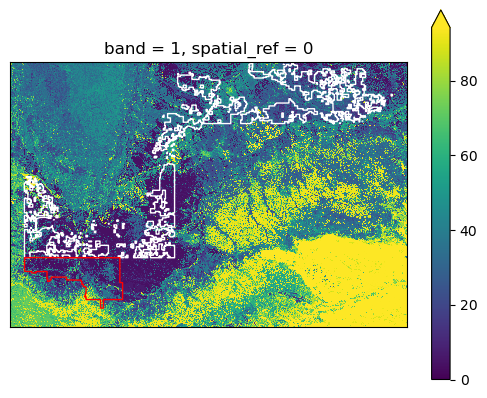

In [8]:
redline_over_index(buffalo_gdf, buffalo_da, cmap='viridis')

## Get MACA and SRTM data

- At least one **climate** variable from the [MACAv2 THREDDS data server](http://thredds.northwestknowledge.net:8080/thredds/reacch_climate_CMIP5_macav2_catalog2.html).
- See [EDA Lesson 3. How to Download MACA2 Climate Data Using Python](https://www.earthdatascience.org/courses/use-data-open-source-python/hierarchical-data-formats-hdf/get-maca-2-climate-data-netcdf-python/).
- [CONUS Page](http://thredds.northwestknowledge.net:8080/thredds/catalog/MACAV2/BNU-ESM/catalog.html?dataset=REACCHDatasetScan_BNU-ESM_MACAV2/macav2metdata_pr_BNU-ESM_r1i1p1_rcp85_2026_2030_CONUS_monthly.nc)
- [OPENDAP](http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/BNU-ESM/macav2metdata_pr_BNU-ESM_r1i1p1_rcp85_2026_2030_CONUS_monthly.nc)
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/BNU-ESM/macav2metdata_pr_BNU-ESM_r1i1p1_rcp85_2026_2030_CONUS_monthly.nc.html
- Scenarios:
Consider climate variables air termperature or precipitation (`_pr_`) with OPENDAP
    - monthly data
    - 5-year interval (2026-30) 
    - RCP45 (current) vs RCP85 (high)
- 

In [5]:
maca_df = process_maca({'buffalo': buffalo_gdf})

In [6]:
maca_df[['site_name', 'scenario', 'climate', 'year']]

,site_name,scenario,climate,year
0,buffalo,pr,rcp85,2026
1,buffalo,pr,rcp45,2026


### Plot MACA

Now what I want to do is be able to plot each of the MACA images.
Borrowing heavily from
[Hannah Rieder Step 3](https://github.com/hanried/habitat-suitability/blob/main/03-habitat-suitability-climate.ipynb).

Year 2026, RCP85, precipitation.

In [8]:
maca_2027 = maca_year(maca_df, 0, 2027)
maca_2027

In [11]:
#maca_2027.plot()

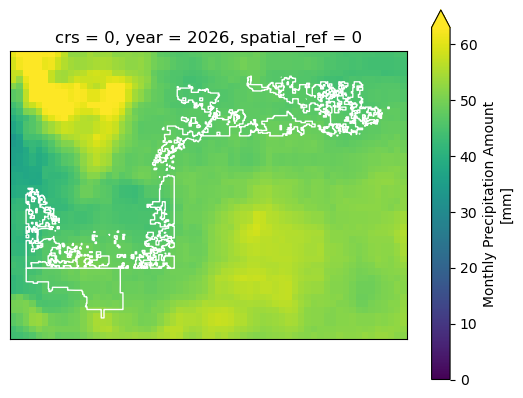

In [27]:
maca_2027 = maca_year(maca_df, 0, 2027)
redline_over_index(buffalo_gdf, maca_2027, edgecolor="white")

Year 2026, RCP45, precipitation.

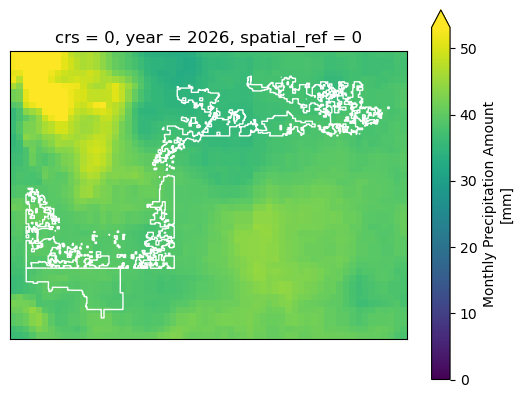

In [28]:
redline_over_index(buffalo_gdf, maca_year(maca_df, 1, 2027), edgecolor="white")

## Slope and Aspect

In [14]:
project_dir = create_data_dir('habitat')
elevation_dir = create_data_dir('habitat/srtm')
elevation_dir

'/Users/brianyandell/earth-analytics/data/habitat/srtm'

In [5]:
earthaccess.login()

In [12]:
datasets = earthaccess.search_datasets(keyword='SRTM DEM', count=11)
for dataset in datasets:
    print(dataset['umm']['ShortName'], dataset['umm']['EntryTitle']) # want 'umn'
# want SRTMGL1? 1 arc second = 30m (also, 3, 30 arc second)

NASADEM_SHHP NASADEM SRTM-only Height and Height Precision Mosaic Global 1 arc second V001
NASADEM_SIM NASADEM SRTM Image Mosaic Global 1 arc second V001
NASADEM_SSP NASADEM SRTM Subswath Global 1 arc second V001
C_Pools_Fluxes_CONUS_1837 CMS: Terrestrial Carbon Stocks, Emissions, and Fluxes for Conterminous US, 2001-2016
SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
GEDI01_B GEDI L1B Geolocated Waveform Data Global Footprint Level V002
GEDI02_B GEDI L2B Canopy Cover and Vertical Profile Metrics Data Global Footprint Level V002
NASADEM_HGT NASADEM Merged DEM Global 1 arc second V001
SRTMGL3 NASA Shuttle Radar Topography Mission Global 3 arc second V003
SRTMGL1_NC NASA Shuttle Radar Topography Mission Global 1 arc second NetCDF V003
SRTMGL30 NASA Shuttle Radar Topography Mission Global 30 arc second V002


In [15]:
%store -r buffalo_gdf
bounds = tuple(buffalo_gdf.total_bounds)
bounds

(np.float64(-104.05473026929808),
 np.float64(42.74093600852109),
 np.float64(-101.47233563761043),
 np.float64(43.99459902288785))

Note label as `hgt` and files are zipped.
Choice of opening or download. We will download

In [19]:
glob(os.path.join(elevation_dir, '*.hgt.zip'))

['/Users/brianyandell/earth-analytics/data/habitat/srtm/N42W102.SRTMGL1.hgt.zip',
 '/Users/brianyandell/earth-analytics/data/habitat/srtm/N43W102.SRTMGL1.hgt.zip',
 '/Users/brianyandell/earth-analytics/data/habitat/srtm/N43W105.SRTMGL1.hgt.zip',
 '/Users/brianyandell/earth-analytics/data/habitat/srtm/N42W105.SRTMGL1.hgt.zip',
 '/Users/brianyandell/earth-analytics/data/habitat/srtm/N43W104.SRTMGL1.hgt.zip',
 '/Users/brianyandell/earth-analytics/data/habitat/srtm/N42W104.SRTMGL1.hgt.zip',
 '/Users/brianyandell/earth-analytics/data/habitat/srtm/N42W103.SRTMGL1.hgt.zip',
 '/Users/brianyandell/earth-analytics/data/habitat/srtm/N43W103.SRTMGL1.hgt.zip']

In [23]:
# This gets list of granules. Only need to do once.
srtm_pattern = os.path.join(elevation_dir, '*.hgt.zip')
if(not glob(srtm_pattern)):
    srtm_results = earthaccess.search_data(
        short_name = 'SRTMGL1',
        bounding_box = bounds
    )
    srtm_results = earthaccess.download(srtm_results, elevation_dir)

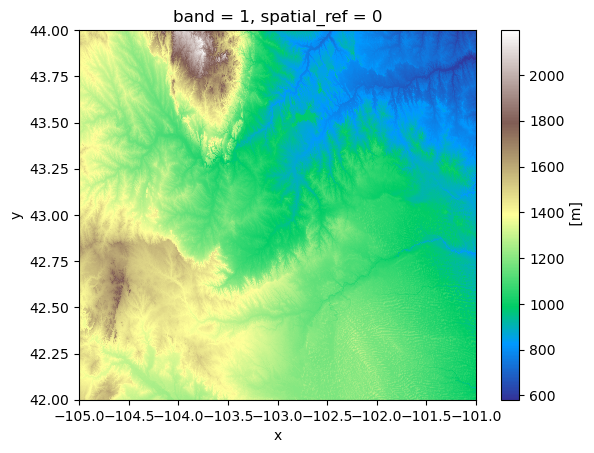

In [32]:
srtm_da_list = []
for srtm_path in glob(srtm_pattern):
    tile_da = rxr.open_rasterio(srtm_path, mask_and_scale=True).squeeze()
    srtm_da_list.append(tile_da)

srtm_da = rxrmerge.merge_arrays(srtm_da_list)
srtm_da.plot(cmap='terrain')

In [ ]:
redline_over_index(buffalo_gdf, srtm_da, edgecolor="white", cmap='terrain')

### Extra Stuff

Below are ideas not implemented.

In [ ]:
# %run srtm.py

## Harmonize Data

Make sure to reproject so all grids line up.